<a href="https://colab.research.google.com/github/DatagirlX/AbasiofonMoses/blob/main/Project_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Project: To bee or not to bee

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import pandas as pd
import cv2
import numpy as np
from skimage.measure import regionprops, label
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN


In [3]:
# Set base path
base_path = '/content/drive/MyDrive/train'
img_path = base_path  # images are directly in 'train'
mask_path = os.path.join(base_path, 'masks')
excel_file = os.path.join(base_path, 'classif.xlsx')

# Check that everything loads properly
print("Sample image files:", os.listdir(img_path)[:5])
print("Sample mask files:", os.listdir(mask_path)[:5])

# Load classification file
df = pd.read_excel(excel_file)
print("Excel file loaded:")
print(df.head())

Sample image files: ['100.JPG', '10.JPG', '1.JPG', '101.JPG', '103.JPG']
Sample mask files: ['binary_100.tif', 'binary_101.tif', 'binary_10.tif', 'binary_1.tif', 'binary_102.tif']
Excel file loaded:
   ID bug type         species
0   1      Bee  Apis mellifera
1   2      Bee  Apis mellifera
2   3      Bee  Apis mellifera
3   4      Bee  Apis mellifera
4   5      Bee  Apis mellifera


1 Feature Extraction

In [4]:
def extract_features(img_id):
    # Paths
    img_file = os.path.join(img_path, f"{img_id}.JPG")
    mask_file = os.path.join(mask_path, f"binary_{img_id}.tif")

    # Load image and mask
    image = cv2.imread(img_file)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Skipping {img_id}: Image not found or unreadable at {img_file}")
        return None
    if mask is None:
        print(f"Skipping {img_id}: Mask not found or unreadable at {mask_file}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = (mask > 0).astype(np.uint8)

    # Apply mask
    bug_pixels = image_rgb[mask == 1]

    # Avoid issues if no bug pixels are found
    if bug_pixels.size == 0:
        print(f"Skipping {img_id}: No bug pixels found in mask")
        return None

    # Pixel ratio
    bug_ratio = np.sum(mask) / (mask.shape[0] * mask.shape[1])

    # Color stats
    R, G, B = bug_pixels[:, 0], bug_pixels[:, 1], bug_pixels[:, 2]
    color_stats = {
        'R_min': np.min(R), 'R_max': np.max(R), 'R_mean': np.mean(R), 'R_median': np.median(R), 'R_std': np.std(R),
        'G_min': np.min(G), 'G_max': np.max(G), 'G_mean': np.mean(G), 'G_median': np.median(G), 'G_std': np.std(G),
        'B_min': np.min(B), 'B_max': np.max(B), 'B_mean': np.mean(B), 'B_median': np.median(B), 'B_std': np.std(B),
    }

    # Regionprops (shape features)
    labeled_mask = label(mask)
    props_list = regionprops(labeled_mask)

    if not props_list:
        print(f"Skipping {img_id}: No labeled regions found")
        return None

    props = props_list[0]
    shape_features = {
        'area': props.area,
        'eccentricity': props.eccentricity,
        'extent': props.extent,
        'solidity': props.solidity,
    }

    # Custom features
    # 1. Hu moments
    moments = cv2.moments(mask)
    hu = cv2.HuMoments(moments).flatten()
    hu_features = {f'hu_{i+1}': hu[i] for i in range(7)}

    # 2. Edge density inside the mask
    edges = cv2.Canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 100, 200)
    edge_density = np.sum(edges[mask == 1]) / np.sum(mask)

    return {
        'ID': img_id,
        'bug_ratio': bug_ratio,
        'edge_density': edge_density,
        **color_stats,
        **shape_features,
        **hu_features,
    }

# Extract features for all images in df['ID']
features = []
for img_id in tqdm(df['ID']):
    try:
        feat = extract_features(img_id)
        if feat:
            features.append(feat)
    except Exception as e:
        print(f"Error processing image {img_id}: {e}")

# Convert to DataFrame
features_df = pd.DataFrame(features)

# Add bug type label
features_df = features_df.merge(df[['ID', 'bug type']], on='ID')

# Preview
print(features_df.head())


 62%|██████▏   | 154/250 [05:55<02:32,  1.59s/it]

Skipping 154: Mask not found or unreadable at /content/drive/MyDrive/train/masks/binary_154.tif


100%|██████████| 250/250 [09:22<00:00,  2.25s/it]

   ID  bug_ratio  edge_density  R_min  R_max      R_mean  R_median      R_std  \
0   1   0.007428      4.355539      5    208   68.085745      56.0  47.955399   
1   2   0.008553      2.304382      2    248   63.786498      55.0  42.153508   
2   3   0.022093      6.291861      3    255  107.176333     114.0  58.771359   
3   4   0.013187      3.505578      5    219   87.588243      88.0  46.322587   
4   5   0.009165      7.314334      6    255  123.177003     134.0  62.355944   

   G_min  G_max  ...    extent  solidity      hu_1      hu_2      hu_3  \
0      3    199  ...  0.506544  0.647039  0.204842  0.000291  0.000433   
1      2    251  ...  0.431831  0.565343  0.235097  0.002576  0.003912   
2      0    255  ...  0.448143  0.627267  0.207384  0.000038  0.002925   
3      3    213  ...  0.427390  0.608743  0.215533  0.006383  0.000159   
4      0    250  ...  0.396221  0.567071  0.251223  0.004548  0.005319   

       hu_4          hu_5          hu_6          hu_7  bug type  
0 

In [5]:
print(features_df.columns)

Index(['ID', 'bug_ratio', 'edge_density', 'R_min', 'R_max', 'R_mean',
       'R_median', 'R_std', 'G_min', 'G_max', 'G_mean', 'G_median', 'G_std',
       'B_min', 'B_max', 'B_mean', 'B_median', 'B_std', 'area', 'eccentricity',
       'extent', 'solidity', 'hu_1', 'hu_2', 'hu_3', 'hu_4', 'hu_5', 'hu_6',
       'hu_7', 'bug type'],
      dtype='object')


2 Data visualization

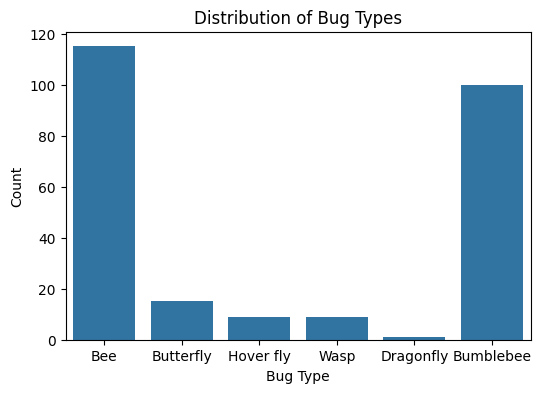

In [6]:
# Bug type
plt.figure(figsize=(6, 4))
sns.countplot(data=features_df, x='bug type')
plt.title("Distribution of Bug Types")
plt.xlabel("Bug Type")
plt.ylabel("Count")
plt.show()

# Species
if 'species' in features_df.columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=features_df, x='species')
    plt.title("Distribution of Species")
    plt.xlabel("Species")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


The dataset is highly imbalanced, with most samples belonging to the Bee and Bumblebee categories.
Underrepresented classes like Hover fly, Wasp, and especially Dragonfly present challenges for supervised learning and affect classifier performance.

#PCA Projection (2D)

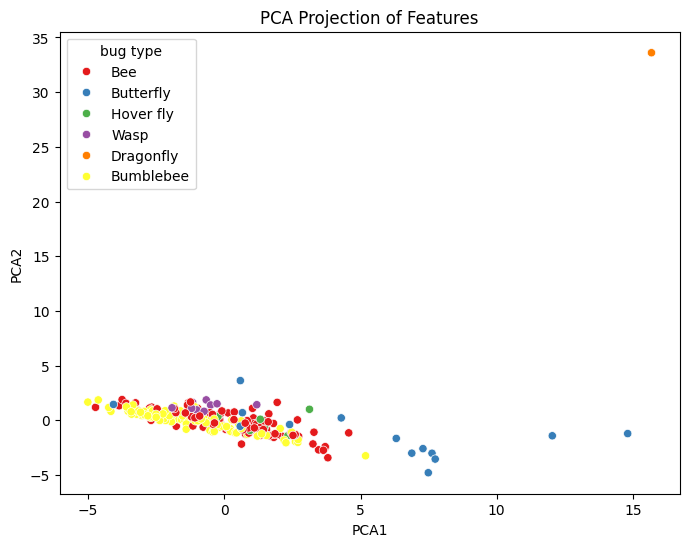

In [7]:
# Drop non-numeric columns
X = features_df.drop(columns=['ID', 'bug type'], errors='ignore')
X = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

# Visualize
pca_df = pd.DataFrame(pca_2d, columns=['PCA1', 'PCA2'])
pca_df['bug type'] = features_df['bug type'].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='bug type', palette='Set1')
plt.title("PCA Projection of Features")
plt.show()


The PCA projection reveals partial separation between bug types.
While some classes like Butterfly and Hover fly form loose clusters, others like Bee and Bumblebee heavily overlap.
This suggests that linear dimensionality reduction alone is insufficient to fully discriminate between classes.

#t-SNE and UMAP Projections (Non-linear)

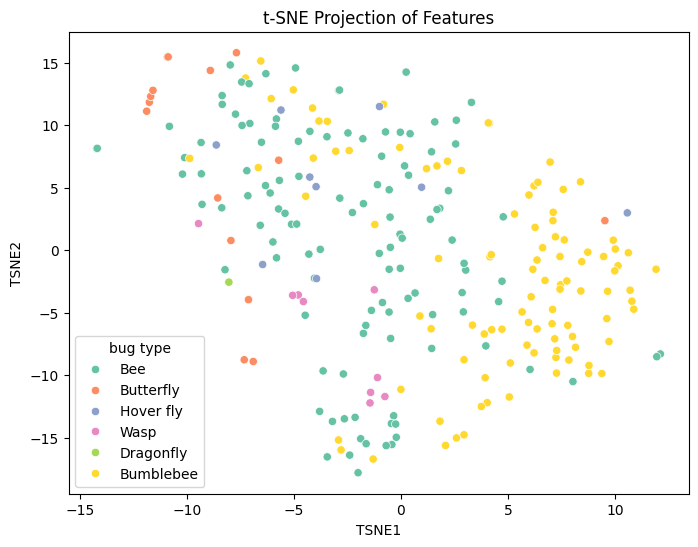

In [8]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_2d = tsne.fit_transform(X)

tsne_df = pd.DataFrame(tsne_2d, columns=['TSNE1', 'TSNE2'])
tsne_df['bug type'] = features_df['bug type'].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='bug type', palette='Set2')
plt.title("t-SNE Projection of Features")
plt.show()


#UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


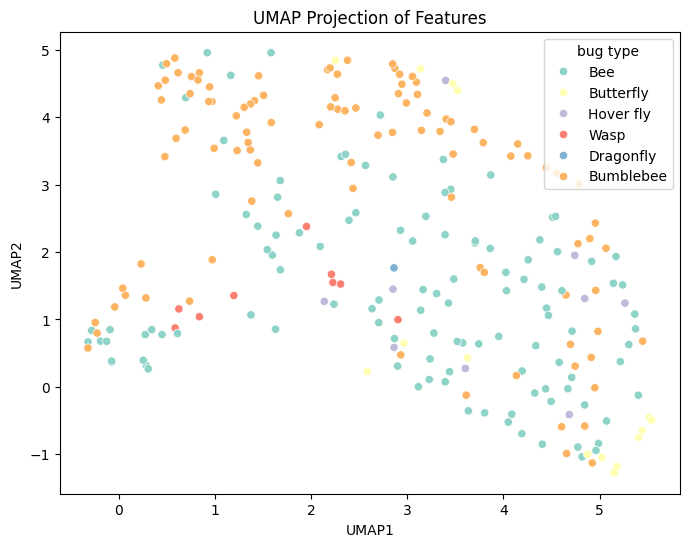

In [9]:
reducer = umap.UMAP(random_state=42)
umap_2d = reducer.fit_transform(X)

umap_df = pd.DataFrame(umap_2d, columns=['UMAP1', 'UMAP2'])
umap_df['bug type'] = features_df['bug type'].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='bug type', palette='Set3')
plt.title("UMAP Projection of Features")
plt.show()


3 Machine Learning and Deep Learning

In [10]:
# Remove bug types with fewer than 2 samples (e.g., Dragonfly)
valid_classes = features_df['bug type'].value_counts()
valid_classes = valid_classes[valid_classes >= 2].index
filtered_df = features_df[features_df['bug type'].isin(valid_classes)].copy()

# Proceed with ML steps
X = filtered_df.drop(columns=['ID', 'bug type'])
y = filtered_df['bug type']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [11]:
features_df['bug type'].value_counts()


,count
bug type,
Bee,115
Bumblebee,100
Butterfly,15
Hover fly,9
Wasp,9
Dragonfly,1


2 Supervised Methods (non-DL, non-ensemble)

In [12]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

# SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("Support Vector Machine")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))


Logistic Regression
              precision    recall  f1-score   support

         Bee       0.78      0.61      0.68        23
   Bumblebee       0.69      1.00      0.82        20
   Butterfly       0.33      0.33      0.33         3
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         2

    accuracy                           0.70        50
   macro avg       0.36      0.39      0.37        50
weighted avg       0.65      0.70      0.66        50

Support Vector Machine
              precision    recall  f1-score   support

         Bee       0.81      0.91      0.86        23
   Bumblebee       0.86      0.95      0.90        20
   Butterfly       1.00      0.67      0.80         3
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         2

    accuracy                           0.84        50
   macro avg       0.53      0.51      0.51        50
weighted avg       0.78      0.84 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Logistic Regression achieved an overall accuracy of 70%.
It performed reasonably well on Bumblebee with perfect recall (1.00) and an F1-score of 0.82, but failed to classify Hover flies and Wasps, likely due to class imbalance and linear decision boundaries.
It's performance was limited by its inability to separate non-linearly distributed classes.

Support Vector Machine (SVM) outperformed Logistic Regression with an accuracy of 84%.
It classified Bee, Bumblebee, and even Butterfly with high precision and recall.
However, similar to Logistic Regression, it completely failed to detect Hover flies and Wasps, which may be due to their small representation in the training data.
The SVM’s kernel helped capture more complex patterns, leading to stronger overall performance.

 1 supervised ensemble learning method (e.g. Random Forest)

In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


Random Forest
              precision    recall  f1-score   support

         Bee       0.76      0.70      0.73        23
   Bumblebee       0.69      1.00      0.82        20
   Butterfly       0.00      0.00      0.00         3
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         2

    accuracy                           0.72        50
   macro avg       0.29      0.34      0.31        50
weighted avg       0.63      0.72      0.66        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest achieved an accuracy of 72%, with strong performance on Bumblebee (F1 = 0.82) and moderate results on Bee (F1 = 0.73).
However, like previous models, it failed to detect Butterfly, Hover fly, and Wasp, likely due to class imbalance and limited training data for those categories.
While ensemble methods like RF are powerful, their effectiveness here was limited by the small sample sizes of minority classes.

#2 Clustering Methods


In [14]:
# KMeans
kmeans = KMeans(n_clusters=len(label_encoder.classes_), random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Attach to features_df for visualization
filtered_df['KMeans_cluster'] = kmeans_labels
filtered_df['DBSCAN_cluster'] = dbscan_labels

from sklearn.metrics import adjusted_rand_score, silhouette_score

# Adjusted Rand Index
ari_kmeans = adjusted_rand_score(y_encoded, kmeans_labels)
ari_dbscan = adjusted_rand_score(y_encoded, dbscan_labels)

# Silhouette Score (only compute if >1 cluster)
n_labels_kmeans = len(set(kmeans_labels))
n_labels_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

sil_kmeans = silhouette_score(X_scaled, kmeans_labels) if n_labels_kmeans > 1 else -1
sil_dbscan = silhouette_score(X_scaled, dbscan_labels) if n_labels_dbscan > 1 else -1

print(f"KMeans ARI: {ari_kmeans:.3f}, Silhouette: {sil_kmeans:.3f}")
print(f"DBSCAN ARI: {ari_dbscan:.3f}, Silhouette: {sil_dbscan if sil_dbscan != -1 else 'N/A'}")



KMeans ARI: 0.202, Silhouette: 0.155
DBSCAN ARI: 0.000, Silhouette: N/A


KMeans achieved an ARI of 0.202, suggesting weak but non-random alignment with true labels.
The Silhouette score of 0.155 indicates overlapping and loosely defined clusters.
While KMeans could roughly group majority classes, it struggled with minority classes due to data imbalance and feature overlap.

DBSCAN failed to produce meaningful clusters (ARI = 0.000), likely due to its sensitivity to density variation and the small size of several bug type classes.
As such, DBSCAN was not suitable for this dataset.



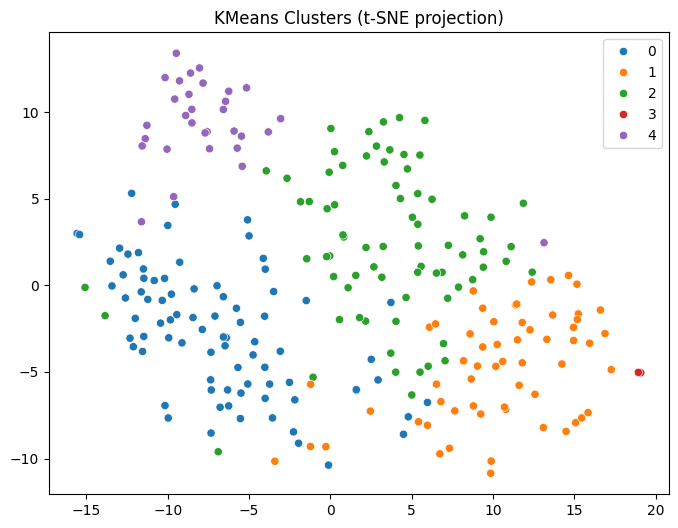

In [15]:
# Recreate X_filtered
X_filtered = filtered_df.drop(columns=['ID', 'bug type', 'KMeans_cluster', 'DBSCAN_cluster'], errors='ignore')
X_filtered_scaled = scaler.fit_transform(X_filtered)

# Redo t-SNE on the same filtered data
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_2d = tsne.fit_transform(X_filtered_scaled)

# Now it will match KMeans labels in size
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_2d[:, 0], y=tsne_2d[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("KMeans Clusters (t-SNE projection)")
plt.show()


1 supervised method  - Grid Search Hyperparameter Tuning

In [16]:
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs'],
    'penalty': ['l2']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
y_pred_grid = grid.predict(X_test)
print("GridSearchCV Logistic Regression")
print("Best Params:", grid.best_params_)
print(classification_report(y_test, y_pred_grid, target_names=label_encoder.classes_))


GridSearchCV Logistic Regression
Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         Bee       0.78      0.61      0.68        23
   Bumblebee       0.69      1.00      0.82        20
   Butterfly       0.33      0.33      0.33         3
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         2

    accuracy                           0.70        50
   macro avg       0.36      0.39      0.37        50
weighted avg       0.65      0.70      0.66        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression with GridSearchCV achieved the same accuracy (70%) and performance as the untuned model, with best parameters: C=1, penalty='l2', solver='lbfgs'.
While it maintained strong performance for Bumblebee (F1 = 0.82) and acceptable performance for Bee (F1 = 0.68), it failed to classify Hover fly and Wasp.
This suggests that further improvements would require either:

Different model types (e.g., non-linear classifiers)

Data augmentation for underrepresented classes

Feature engineering or rebalancing techniques (e.g., SMOTE)

Deep Learning Method

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=16)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0687 - loss: 1.8978 - val_accuracy: 0.2750 - val_loss: 1.6311
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4148 - loss: 1.6128 - val_accuracy: 0.5000 - val_loss: 1.4518
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5934 - loss: 1.4020 - val_accuracy: 0.5500 - val_loss: 1.3177
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6585 - loss: 1.1281 - val_accuracy: 0.5750 - val_loss: 1.2176
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7214 - loss: 1.0583 - val_accuracy: 0.5750 - val_loss: 1.1456
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7191 - loss: 0.9953 - val_accuracy: 0.5750 - val_loss: 1.0910
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7671 - loss: 0.8398 - val_accuracy: 0.6000 - val_loss: 1.0587
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7577 - loss: 0.8090 - val_accuracy: 0.6000 - val_loss

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7433 - loss: 0.6480
Test Accuracy: 0.74


In [19]:
y_pred_dl = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_dl, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
              precision    recall  f1-score   support

         Bee       0.76      0.70      0.73        23
   Bumblebee       0.73      0.95      0.83        20
   Butterfly       0.67      0.67      0.67         3
   Hover fly       0.00      0.00      0.00         2
        Wasp       0.00      0.00      0.00         2

    accuracy                           0.74        50
   macro avg       0.43      0.46      0.44        50
weighted avg       0.68      0.74      0.70        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Evaluation on Test Data (Images 251–347)

In [20]:
test_features = []
for img_id in tqdm(range(251, 348)):  # 348 because range is exclusive at the end
    feat = extract_features(img_id)
    if feat:
        test_features.append(feat)

test_features_df = pd.DataFrame(test_features)


100%|██████████| 97/97 [03:30<00:00,  2.17s/it]


In [21]:
X_final = test_features_df.drop(columns=['ID'])
X_final_scaled = scaler.transform(X_final)
final_preds = svm.predict(X_final_scaled)
final_labels = label_encoder.inverse_transform(final_preds)


In [22]:
submission = pd.DataFrame({
    'ID': test_features_df['ID'],
    'bug type': final_labels
})
submission.to_csv('submission.csv', index=False)
print("Final predictions saved to submission.csv")


Final predictions saved to submission.csv
